In [5]:
!pip install -q --upgrade transformers diffusers ftfy

In [4]:
!pip install transformers

  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)


In [6]:
from base64 import b64decode

import numpy
import torch

from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Loading Models

In [7]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = 'vae')

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\adima\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [8]:
!pip install accelerate

                                              0.0/227.6 kB ? eta -:--:--
     -                                        10.2/227.6 kB ? eta -:--:--
     -                                        10.2/227.6 kB ? eta -:--:--
     -                                        10.2/227.6 kB ? eta -:--:--
     -                                        10.2/227.6 kB ? eta -:--:--
     -                                        10.2/227.6 kB ? eta -:--:--
     ----------------------               143.4/227.6 kB 502.3 kB/s eta 0:00:01
     ----------------------               143.4/227.6 kB 502.3 kB/s eta 0:00:01
     ---------------------------          174.1/227.6 kB 499.5 kB/s eta 0:00:01
     ------------------------------       194.6/227.6 kB 472.6 kB/s eta 0:00:01
     --------------------------------     204.8/227.6 kB 461.0 kB/s eta 0:00:01
     --------------------------------     204.8/227.6 kB 461.0 kB/s eta 0:00:01
     -----------------------------------  225.3/227.6 kB 393.1 kB/s eta 0:00:

In [9]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

In [10]:
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [11]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

## Diffusion Loop

In [35]:
prompt = ["A watercolor painting of an platypus"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1


In [36]:
## Preparing the text
text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length,truncation=True, 
                       return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding = "max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings,text_embeddings])

In [37]:
#Preparing the Scheduler
scheduler.set_timesteps(num_inference_steps)

In [38]:
#Prep latents
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width//8),
    generator = generator,
)
letents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

In [39]:
## Creating a Loop
with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        latent_model_input = torch.cat([latents] *2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        latent_model_input = latent_model_input.to(torch_device)
        # to preduct residual noise
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings).sample
        
        #perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        noise_pred=noise_pred.to(torch_device)
        latents = scheduler.step(noise_pred,t.to(torch_device),latents.to(torch_device)).prev_sample

0it [00:00, ?it/s]

In [47]:
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

C:\Users\adima\AppData\Local\Temp\ipykernel_7868\859665460.py:3: RuntimeWarning: invalid value encountered in cast
  images = (image * 250).round().astype("uint8")


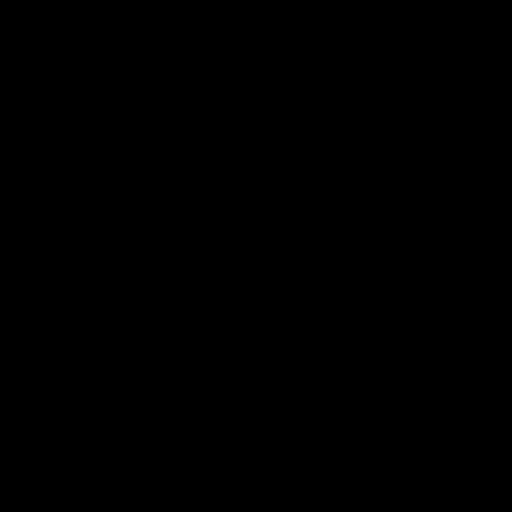

In [46]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 250).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]